In [1]:
%matplotlib inline
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

from matplotlib import rcParams
rcParams['figure.figsize'] = (10, 5)   # Change this if figures look ugly. 
rcParams['font.size'] = 16
# IPython Libraries
import IPython
import ipywidgets
from ipywidgets import interact, interactive, interact_manual

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from gradient_descent import Objective, plot_2d_objective, gradient_descent, gradient_descent_momentum

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plotting utilities

In [2]:
def plot_data(X, Y, fig=None, options=dict()):
    # fig_data = plt.figure()
    if fig is None:
        fig = plt.subplot(111)
    fig.plot(X, Y, options.get('marker', 'b*'), 
        label=options.get('label', 'Raw data'),
        linewidth=options.get('linewidth', 2),
        fillstyle=options.get('fillstyle', 'full'),
        ms=options.get('size', 8))
    process_plot(fig, options)
    
def plot_fit(X, w, fig=None, options=dict()):
    if fig is None:
        fig = plt.subplot(111)

    x_min = np.min(X)
    x_max = np.max(X)
    dim = w.size - 1
    x_plot = np.reshape(np.linspace(x_min, x_max, 100), [-1, 1])
    x1_plot = np.ones_like(x_plot)
    for d in range(dim):
        x1_plot = np.concatenate((np.power(x_plot, 1 + d), x1_plot), axis=1)

    y_plot = np.dot(x1_plot, w)
    fig.plot(x_plot, y_plot, label=options.get('label', 'Regression fit'))
    process_plot(fig, options)
    
def process_plot(fig, options=dict()):
    if 'x_label' in options.keys():
        fig.set_xlabel(options['x_label'])
    if 'y_label' in options.keys():
        fig.set_ylabel(options['y_label'])
    if 'x_lim' in options.keys():
        fig.set_xlim(options['x_lim'])
    if 'y_lim' in options.keys():
        fig.set_ylim(options['y_lim'])
    if 'title' in options.keys():
        fig.set_title(options['title'])
    if 'legend' in options.keys():
        if options['legend']:
            fig.legend(loc=options.get('legend_loc', 'best'))

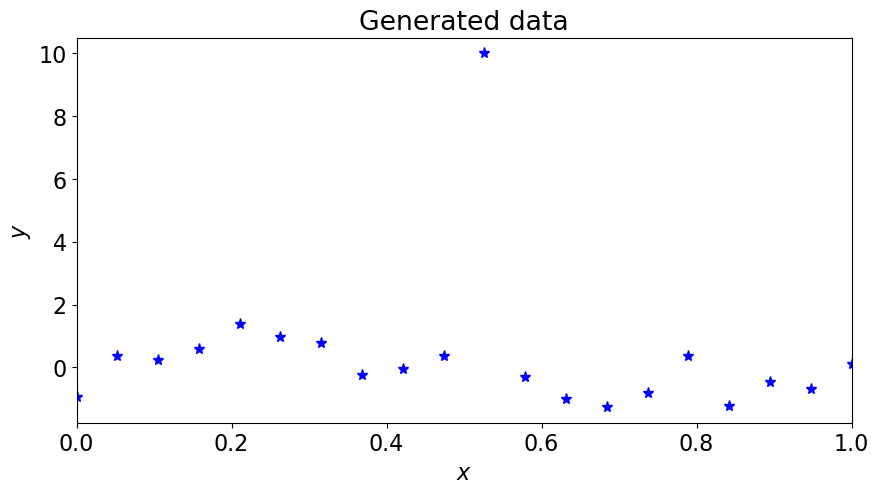

In [3]:
rcParams['figure.figsize'] = (10, 5)   # Change this if figures look ugly. 
rcParams['font.size'] = 16

num_points = 20 # Number of training points.
noise = 0.5  # Noise Level (needed for data generation).

def generate_data(num_points, noise_level):
    # Function used for generating the true dataset
    x = np.linspace(0, 1, num_points).reshape(-1, 1)
    y = np.sin(2 * np.pi * x) + np.random.normal(scale=noise_level, size=(x.shape[0], 1))
    return x, y

X, y = generate_data(num_points, noise)
y[10] = 10 # create outlier

# Plot Data
fig = plt.subplot(111);
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Generated data', 'x_lim':[0,1], 'y_lim': [np.min(y)-0.5, np.max(y)+0.5]}
plot_data(X, y, fig=fig, options=plot_opts)

## Generate polynomial feature matrix

In [4]:
def generate_polynomial(x, degree):
    X = np.ones((x.shape[0], 1))
    for index in range(degree):
        X = np.concatenate([x**(index + 1), X], axis=1)
    return X

degree = 3
Phi = generate_polynomial(X, degree=degree)

In [5]:
np.linalg.cond(Phi.T.dot(Phi))

11972.043581901056

## Compute Closed Form Solution

In [6]:
w_hat = np.linalg.solve(np.dot(Phi.T, Phi), np.dot(Phi.T, y))

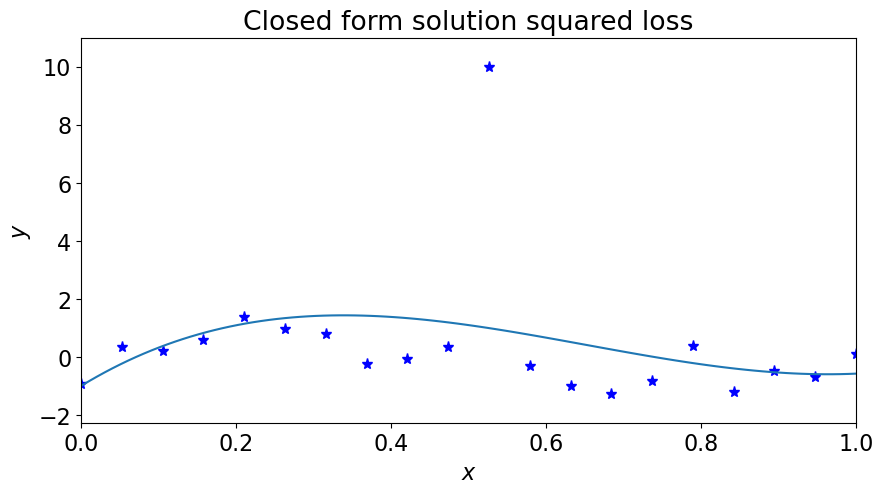

In [7]:
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Closed form solution squared loss', 'legend': False,
             'x_lim':[0,1],'y_lim': [np.min(y)-1, np.max(y)+1]}

plot_data(X, y, fig=fig, options=plot_opts)
plot_fit(X, w_hat, fig=fig, options=plot_opts)

## Huber loss

In [8]:
class HuberLoss(Objective):
    def __init__(self, tau, Phi, y):
        self.tau = tau
        self.Phi = Phi
        self.y = y
        
    def __call__(self, w):
        r = self.y - self.Phi.dot(w)
        mask = np.abs(r) < self.tau
        return np.sum(0.5*r[mask]**2) + np.sum(self.tau*np.abs(r[True^mask] - self.tau**2))
    
    def grad(self, w):
        r = self.y - self.Phi.dot(w)
        mask = np.abs(r) < self.tau
        grad_huber = r.copy()
        grad_huber[True^mask] = self.tau*np.sign(r[True^mask])
        return -self.Phi.T.dot(grad_huber)    

In [9]:
loss_huber = HuberLoss(1.35, Phi, y[:,0])

In [10]:
learning_rate = 0.01
tol = 1e-8
n_steps = 100000
w_init = np.zeros(Phi.shape[1])

In [11]:
w_grad, _, _ = gradient_descent_momentum(loss_huber, w_init, n_steps=n_steps, learning_rate=learning_rate, tol=tol)

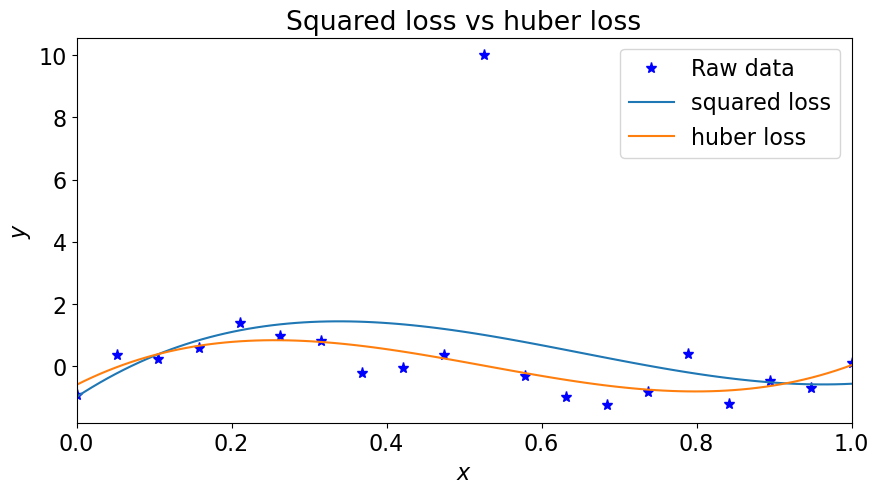

In [12]:
fig = plt.subplot(111)
plot_opts = {'x_label': '$x$', 'y_label': '$y$', 'title': 'Squared loss vs huber loss', 'legend': False,
             'x_lim':[0,1]}

plot_data(X, y, fig=fig, options=plot_opts)
plot_opts['label'] = 'squared loss'
plot_fit(X, w_hat, fig=fig, options=plot_opts)
plot_opts['label'] = 'huber loss'
plot_fit(X, w_grad[:, np.newaxis], fig=fig, options=plot_opts)
plt.legend()